### Custom datasets

In [ ]:
# Importing pytorch + device agnostic code

import torch
from torch import nn

torch.__version__

'1.13.0+cu116'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. get data
dataset is a subset for the food101 dataset

food101 starts with 101 different classes of food and 100 images per class

In [ ]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"
# if the image folder doesnt exist
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one")
  image_path.mkdir(parents=True, exist_ok=True)
# download the pictures
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading image")
  f.write(request.content)
# unzip
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping the images")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping the images


## 2. Data preparation and exploration



In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} image in {dirpath}.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 image in data/pizza_steak_sushi.
There are 3 directories and 0 image in data/pizza_steak_sushi/train.
There are 0 directories and 72 image in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 image in data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 image in data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 image in data/pizza_steak_sushi/test.
There are 0 directories and 31 image in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 image in data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 image in data/pizza_steak_sushi/test/pizza.


In [ ]:
# setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"

### 2.1 visualizing and image

1. get all of the image paths
2. pick a random image path using python's random.choice()
3. get the image class name `pathlib.Path.parent.stem`
4. open the image with python PIL
5. show the image and print metadata

Random image path: data/pizza_steak_sushi/train/sushi/1575445.jpg
Image class: sushi
Image height: 307
Image width: 512


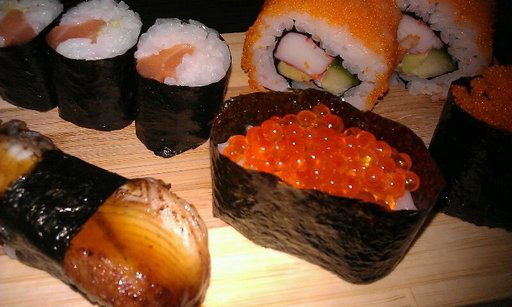

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

# print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

Text(0.5, 0, 'sushi')

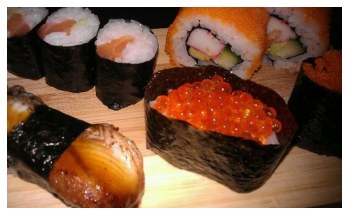

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(img)
plt.axis(False)
plt.xlabel(image_class)

(-0.5, 511.5, 306.5, -0.5)

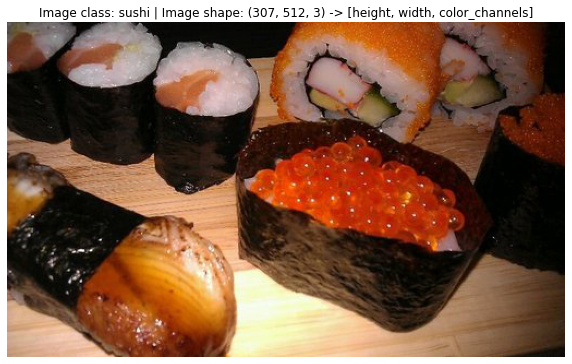

In [ ]:
img_as_array = np.asarray(img)
# plot the img with plt
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [ ]:
img_as_array

array([[[ 79,  74,  81],
        [ 86,  81,  87],
        [ 89,  85,  86],
        ...,
        [  3,   1,   2],
        [  5,   3,   4],
        [  6,   4,   7]],

       [[ 94,  89,  95],
        [102,  97, 101],
        [105, 101, 100],
        ...,
        [  4,   2,   3],
        [  5,   3,   4],
        [  6,   4,   5]],

       [[ 96,  91,  95],
        [104, 100, 101],
        [107, 101, 101],
        ...,
        [  4,   2,   3],
        [  4,   2,   3],
        [  5,   3,   4]],

       ...,

       [[189, 143, 119],
        [191, 145, 121],
        [191, 145, 121],
        ...,
        [ 17,   9,   7],
        [ 18,   8,   7],
        [ 17,   7,   6]],

       [[192, 146, 122],
        [194, 148, 124],
        [194, 148, 124],
        ...,
        [ 17,   9,   7],
        [ 18,   8,   7],
        [ 17,   7,   6]],

       [[193, 147, 123],
        [195, 149, 125],
        [197, 151, 127],
        ...,
        [ 17,   9,   7],
        [ 17,   7,   6],
        [ 16,   6,   5]]

# turn all images into tensors
1. numerical representation of our images
2. turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data



In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# 3.1 Transforming data with `torchvision.transforms`

In [ ]:
data_transform = transforms.Compose([
    # resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

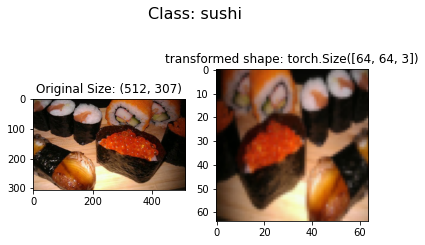

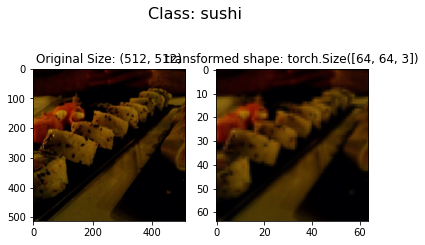

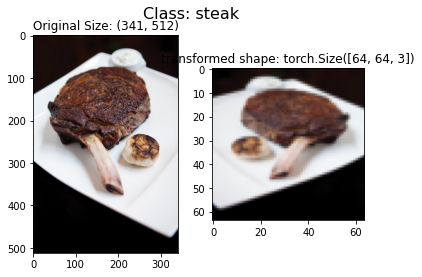

In [ ]:
# visualize transformed images
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms them then plots the orignal vs the transformed version
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original Size: {f.size}")
      # transform and plot target image

      transformed_image = transform(f).permute(1, 2, 0) # changing the order of the dimensions
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed shape: {transformed_image.shape}")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                              transform=data_transform,
                              n=3,
                              seed=42)


# 4. Option 1: Loading image data using ImageFolder

we can load image classification dat ausing `torchvision.datasets.ImageFolder`


In [ ]:
# use imagefloder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
# index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label datatype: {type(label)}")

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

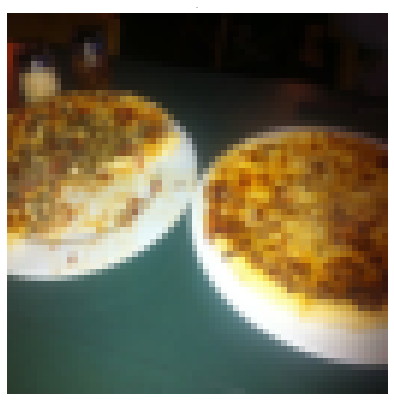

In [ ]:
## rearrange the order dimension

img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original shape: {img.shape} -> [color channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=1)


## 4.1 turn loaded images into dataloaders

A dataloader helps turn our dataset into iterables
and we can customize batch_size so our model can see batch_size images at a time

In [ ]:
# turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # you can use os.cpu_count() for more
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers = 1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f834ba93a30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f834ba93610>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# batch size will now be 1

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 option 2 loading image data with custom dataset

1. want to be able to load images from file
2. want to be able to get class names from the dataset
3. want to be able to get classes from dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# all custom datasets subclass torch.utils.data.Dataset

### 5.1 creating a helper funciton to get class names

we want a function to:
1. get the class names using os.scandir() to traverse a target directory
2. raise an error if the class names arent found
3. turn the class names into a dict and a list and return them

In [ ]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

# get the class names from the target directory

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory
  """
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
  class_to_idx = {class_name: i for i, class_name in enumerate(classes) }
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 create a custom dataset to replicate imagefolder

1. subclass torch.utils.data.Dataset
2. init subclass w target directory as well as a transform
3. create several attributes
  * paths - paths of our images
  * transform - teh transforms
  * classes
  * class_to_idx
4. Create a function to load_images()
5. overwrite the __len__() method
6. overwrite the __getitem__() method

In [ ]:
# write a custom dataset class
from torch.utils.data import DataLoader

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    super().__init__()
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transforms
    self.transform = transform
    # create class and class to idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

    # create a fucntion to load iamges

  def load_image(self, index: int) -> Image.Image:
    """opens an image via a path"""
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    """returns the total number of samples"""
    return len(self.paths)

  # 6 overwrite __getitem__()

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one smaple of data, data and label (X, y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format
    class_idx = self.class_to_idx[class_name]

    # transform if necessary

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
# create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# test our imagefolder custom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# check for equality between orginal ImageFolder Dataset and custom
print(train_data.classes == train_data_custom.classes)

True


In [ ]:
print(train_data.class_to_idx == train_data_custom.class_to_idx)

True


import matplotlib
### 5.3 create a function to dispaly random images

1. takin in a dataset and other params
2. prevent dispaly getting out of hand, cap images
3. set random seed
4. list of random sample from the target dataset
5. setup a matplotlib plot
6. loop through the random sample images and plot then with matplotlib
7. make sure dimension line up

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print("N shouldnt be larger than 10, removing shape display")
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k = n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


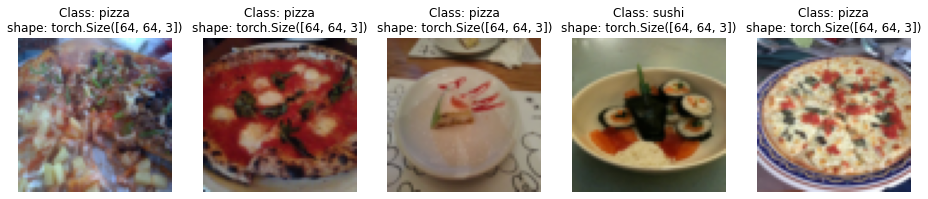

In [ ]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

N shouldnt be larger than 10, removing shape display


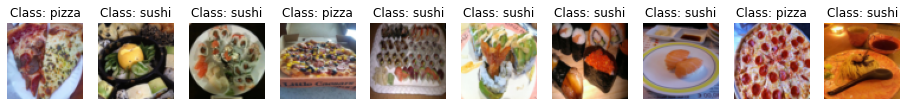

In [ ]:
# display random iamges from the image folder custom dataset

display_random_images(train_data_custom,
                      n=20,
                      classes=train_data_custom.classes,
                      seed = 42)

In [ ]:
### Turn custom loaded images into dataloader

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8347e12340>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8347e12c10>)

In [ ]:
# get image and label from custom dataloader

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

### other forms of transforms (data augmentation)

data augmentation is the process of artificially adding diversity to your training data

in the case of image data, apply slight changes

how pytorch trainied its vision models to state of the art levels

In [ ]:
# lets look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/424994.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1551817.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2873571.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/794647.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/200025.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/843815.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/821108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/497686.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/390178.jpg')]

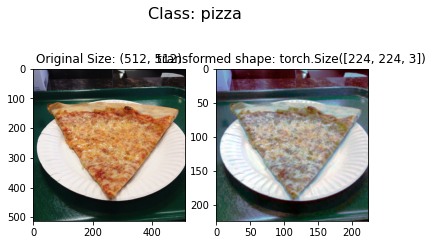

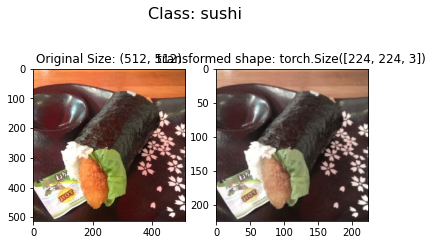

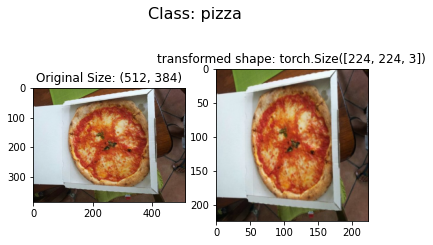

In [ ]:
# plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

lets replicate tinyvgg architecure from the cnn explainer website

In [ ]:
## 7.1 Creating transforms and loading data for model 0

# Create simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [ ]:
# load and transform data

from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn datasets into dataloaders

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

In [ ]:
# 7.2 create Tiny VGG Model Class
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self,
              input_shapes: int,
              hidden_units: int,
              output_shapes: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shapes,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is the same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is the same as kernel size
    )
    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shapes)
    )

  def forward(self, x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifer(x)
    # print(x.shape)
    # return x
    return self.classifer(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shapes=3,
                  hidden_units=10,
                  output_shapes=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
### 7.3 Try a forward pass on a single image (to test the model)
# get a single image batch

image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2870e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7294e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8249e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [ ]:
### 7.4 Use torchinfo to get an idea of the shapes going through our model

try:
  import torchinfo
except:
  %pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 create train and test loop

* train_step()
* test_step()

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # adjust metrics to get avg loss and acc
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc




In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss

      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  # adjust metrics to get avg loss and acc
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               test_dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               device=device,
               epochs: int = 5,
               loss_fn: torch.nn.Module = nn.CrossEntropyLoss()):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # update results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
## 7.7 train and eval model 0
torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

In [ ]:
EPOCHS = 5

model_0 = TinyVGG(input_shapes=3,
                  hidden_units=10,
                  output_shapes=len(train_data.classes)).to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

In [ ]:
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

end_time = timer()
print(f"total training time: {end_time-start_time:.3f} second")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1034 | Train acc: 0.2500 | Test loss: 1.0994 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0762 | Train acc: 0.4258 | Test loss: 1.1299 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0723 | Train acc: 0.4258 | Test loss: 1.1609 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1057 | Train acc: 0.3047 | Test loss: 1.1465 | Test acc: 0.2708
Epoch: 4 | Train loss: 1.0825 | Train acc: 0.3672 | Test loss: 1.1490 | Test acc: 0.2500
total training time: 18.836 second


In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
from timeit import default_timer as timer
EPOCHS = 5
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0935 | train_acc: 0.3945 | test_loss: 1.1462 | test_acc: 0.2812
Epoch: 2 | train_loss: 1.0222 | train_acc: 0.5352 | test_loss: 1.1242 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.0270 | train_acc: 0.5391 | test_loss: 1.0988 | test_acc: 0.3021
Epoch: 4 | train_loss: 1.0316 | train_acc: 0.4766 | test_loss: 1.0671 | test_acc: 0.3731
Epoch: 5 | train_loss: 0.9668 | train_acc: 0.4688 | test_loss: 0.9557 | test_acc: 0.4934
Total training time: 10.479 seconds


## 7.8 plot the loss curves of model 0

A loss curve is a way of tracking your model's progress over time



In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""
  loss = results["train_loss"]
  test_loss=results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  # figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  # plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

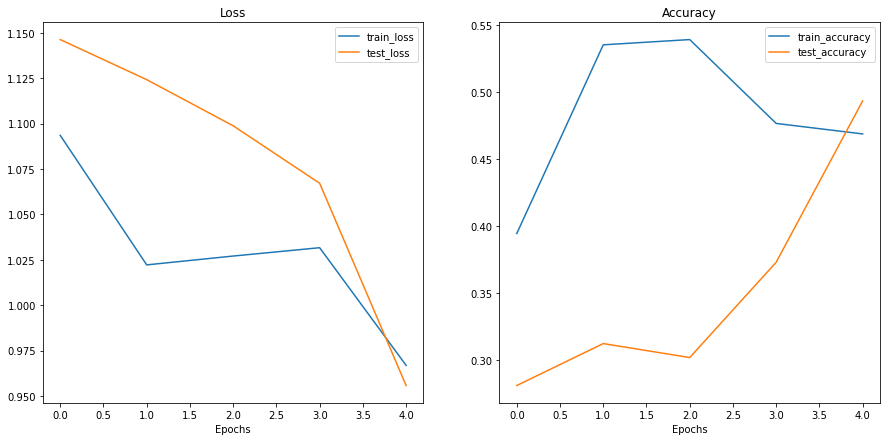

In [ ]:
plot_loss_curves(model_0_results)

## 9 TinyVGG with data augmentation



## 9.1 Create transform with data augmentation


In [ ]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
## 9.2 create train and test dataset and dataloaders with data augmentation

# turn image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_trivial)

In [ ]:
# turn our datasets into dataloader
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shapes=3,
                  hidden_units=10,
                  output_shapes=len(train_data_augmented.classes)).to(device)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001)

In [ ]:
start_time = timer()
model_1_results = train(model=model_1,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader_simple,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=5,
      device=device
      )
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0890 | train_acc: 0.4258 | test_loss: 1.1081 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1022 | train_acc: 0.3047 | test_loss: 1.1063 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1028 | train_acc: 0.3047 | test_loss: 1.1073 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1020 | train_acc: 0.3047 | test_loss: 1.1055 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0889 | train_acc: 0.4258 | test_loss: 1.1064 | test_acc: 0.2604
Total training time for model_1: 14.547 seconds


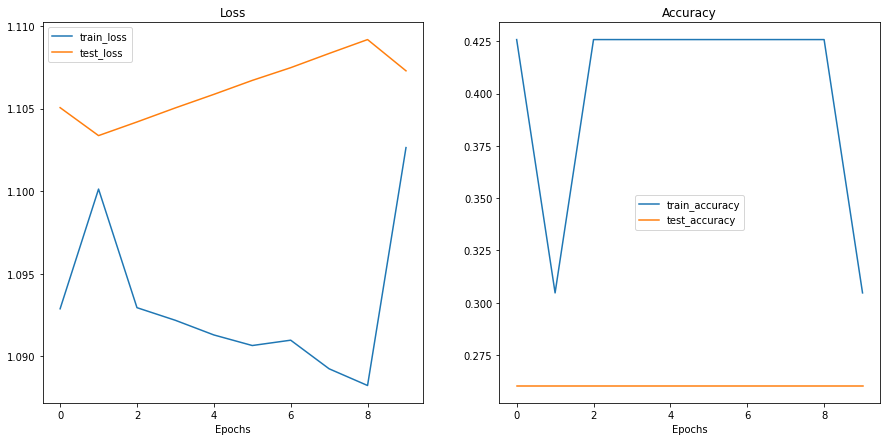

In [ ]:
plot_loss_curves(model_1_results)

## `torch.utils.tensorboard`
# compare model results

after eval our modelling experiments on their own, its important to compare your model results

1. hard coding
2. tensorboard
3. weights + biases
4. MLFlow

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [ ]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.093481,0.394531,1.146242,0.281250
1,1.022158,0.535156,1.124174,0.312500
2,1.027023,0.539062,1.098762,0.302083
3,1.031615,0.476562,1.067111,0.373106
4,0.966815,0.468750,0.955726,0.493371


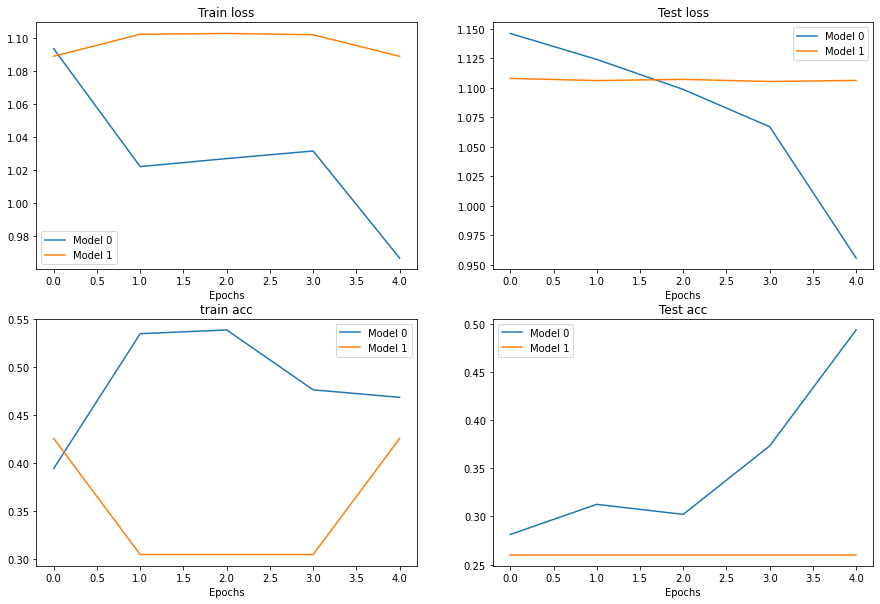

In [ ]:
## setup a plot

plt.figure(figsize=(15, 10))
# get number of epochs
epochs = range(len(model_0_df))
# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("train acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

# 11. making a prediction on a custom image

although we've trained the model, how do we make a prediction on a custom image

In [ ]:
# download custom image

import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print("Already downloaded")


## 11.1 Loading in a custom image with pytorch

we have to make sure our custom image is in the same format as the data our model was trained of

* in tensor form with datatype (torch.float32)
* of shape 64x64x3
* on the right device

In [ ]:
import torchvision
# read in custom image

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dat

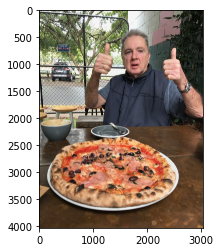

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

In [ ]:
custom_image_float32 = custom_image_uint8.type(torch.float32) / 255
custom_image_float32.dtype

torch.float32

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [ ]:
formatted_custom_image_float32 = transform(custom_image_float32)
permuted_custom_image_float32 = formatted_custom_image_float32.permute(1, 2, 0)

## 11.2 making a prediction on a custom iamge with a trained pytorch model


In [ ]:
formatted_custom_image_float32.shape

torch.Size([3, 64, 64])

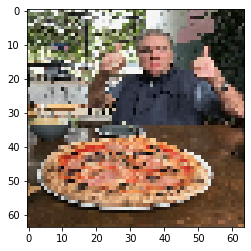

In [ ]:
plt.imshow(permuted_custom_image_float32)

In [ ]:
# dont forget to add a batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(formatted_custom_image_float32.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0879, -0.0308, -0.0284]])

* load the image and turn it into a tensor
* make sure the image was the same datatype as the model (torch.float32)
* batch size (shape of the tensor)
* same device


In [ ]:
# convert logits to pred probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3599, 0.3197, 0.3204]])

In [ ]:
# convert the prediction probabilities -> prediction labels

custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

## 11.3 Putting custom image prediction together: buildign a function

ideal outcome:
a function where we pass an image path to and have our model predict on that image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        img_path: str,
                        class_names: List[str]=None,
                        transform=None,
                        device=device):
  """Make a prediction on a target image with a trained model and plots the image and prediction"""
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  # divide the image pixel valeus by 255
  target_image = target_image/ 255

  # transform if necessary
  if transform:
    print(target_image)
    target_image = transform(target_image)

  # make sure the model is on the target device
  model.to(device)

  model.eval()
  with torch.inference_mode():
    # add an extra dimension to the iamge (this is the batch dimension)
    target_image = target_image.unsqueeze(0)

    # make a prediction
    target_image_pred = model(target_image.to(device))

    # convert logits to pred prob
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # convert prediction prob to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dim and rearrange

    if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob {target_image_pred_probs.max().cpu():.3f}"
    else:
      title = f"Pred: {target_image_pred_label} | Prob {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

In [ ]:
pred_and_plot_image(model=model_1,
                    transform=transform,
                    img_path=custom_image_path,
                    class_names=class_names,
                    device=device)